Range: 15996um to 16008um (12um)
Bins:
 - Low (l):          15996-15999um
 - Medium low (ml):  15999-16002um
 - Medium high (mh): 16002-16005um
 - High (h):         16005-16008um
Mean: 16002.70588235294
Median: 16002
Mode: 16002
Chips at median height: 83, 84, B4, A5, 95, A6, B6, C6, B7, A7, 17, 28, 38, 48, 58, 68, 78, 88, 98, A8, B8, A9, 89, 69, 59, 49, 39, 29, 7A, 8A, 9A, 8B, 7B


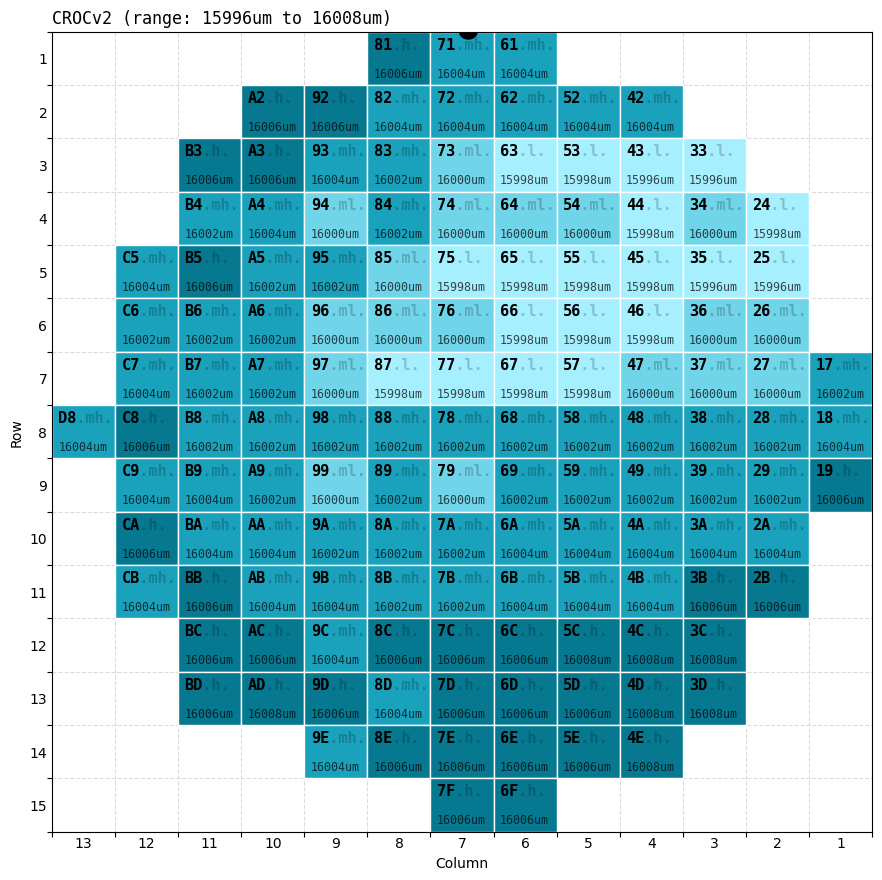

In [15]:
#Topography map draft
#TODO: 
    #Do something with Asymmetry?

import os
import numpy as np
from scipy import stats
import re
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker
from wlt.duts.wafers import WAFER_MAPS
from wlt.wafermap import WaferMap

#Open file
with open(os.path.expanduser('~/Desktop/log_files/2nd_probe_card/wafer_NC0W14-03B6_20240627_115829.log'), 'r') as file:
    log_content = file.readlines()

#Set up patterns
waferpattern = r'Wafer: (\w\w\w\w)'
waferid = ""
chippattern = r'(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3}) \| WaferTester \((\S\S\S\S)\)   \| INFO     \| Testing chip \S\S\S\S\S\S\S\S\S\S\S\S(\S\S)'
contactpattern = r'(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3}) \| WaferTester \((\S\S\S\S)\)   \| INFO     \| Found contact height: (.*)'
chipids = []
contactheight = []
for line in log_content:
    chipmatch = re.search(chippattern, line)
    contactmatch = re.search(contactpattern, line)
    wafermatch = re.search(waferpattern, line)
    if chipmatch:
        chipid = str(chipmatch.group(3))
        chipids.append(chipid)
    elif contactmatch:
        contactheight.append(contactmatch.group(3))
    elif wafermatch:
        waferid = str(wafermatch.group(1))
                             
#Organize data
contactheight = [int(i[:5]) for i in contactheight]

#Format chips (e.g. A9 is (10,9))
chip_coords = [f'({s[0]},{s[1]})' for s in chipids]
letter_to_number = {
    'A': '10', 'B': '11', 'C': '12', 'D': '13', 'E': '14', 'F': '15'}
def multiple_substitutions(s):
    pattern = re.compile('|'.join(map(re.escape, letter_to_number.keys())))
    return pattern.sub(lambda match: letter_to_number[match.group(0)], s)
chiplocations = [multiple_substitutions(s) for s in chip_coords]

#determine status ranges
min_height = min(contactheight)
max_height = max(contactheight)
height_range = max_height - min_height
bin_size = height_range / 4.0

#sort chips into statuses
low = []
medlow = []
medhigh = []
high = []
low_c = []
medlow_c = []
medhigh_c = []
high_c = []
for i in range(len(contactheight)):
    value_height = contactheight[i]
    value_chip = chiplocations[i]
    if value_height < min_height + bin_size:
        low.append(value_chip)
        low_c.append(value_height)
    elif value_height < min_height + 2 * bin_size:
        medlow.append(value_chip)
        medlow_c.append(value_height)
    elif value_height < min_height + 3 * bin_size:
        medhigh.append(value_chip)
        medhigh_c.append(value_height)
    else:
        high.append(value_chip)
        high_c.append(value_height)

#find out which chips are at the median height
median_chips = []
for i in range(len(contactheight)):
    if contactheight[i] == np.median(contactheight):
        median_chips.append(chipids[i])

#make dictionaries
low_dict = {k:v for k,v in zip(low,low_c)}
medlow_dict = {k:v for k,v in zip(medlow,medlow_c)}
medhigh_dict = {k:v for k,v in zip(medhigh,medhigh_c)}
high_dict = {k:v for k,v in zip(high,high_c)}

#set statuses
chip_statuses = {
		( 1, ''): low_dict,    
		( 2, ''): medlow_dict,                
		( 3, ''): medhigh_dict, 
		( 4, ''): high_dict,              
    }

WaferMap.STATUS_COLORS = {1: '#A5EFFE', 2: '#71d5ea', 3: '#1aa1bc', 4: '#067991'}
WaferMap.STATUS_NAMES =  {1: 'l',       2: 'ml',       3: 'mh',       4: 'h'}

#Create map
loop = 0
ch_type ='CROCv2'
wafer_map = WaferMap(chip_type=ch_type, title=f'{ch_type} (range: {min_height}um to {max_height}um)')
for (chip_status, chip_value), x in chip_statuses.items():
    for chips,heights in x.items():
        subtext = f"{heights}um"
        wafer_map.set_chip(eval(chips), chip_status, subtext)
        loop = loop + 1

#printing stats
print(f'Range: {min_height}um to {max_height}um ({max_height-min_height}um)')
print(f'Bins:\n - Low (l):          {min_height}-{int(min_height+bin_size)}um\n - Medium low (ml):  {int(min_height+bin_size)}-{int(min_height+bin_size*2)}um\n - Medium high (mh): {int(min_height+bin_size*2)}-{int(min_height+bin_size*3)}um\n - High (h):         {int(min_height+bin_size*3)}-{int(max_height)}um')
print(f'Mean: {np.mean(contactheight)}')
print(f'Median: {int(np.median(contactheight))}')
print(f'Mode: {stats.mode(contactheight)[0]}')
print(f'Chips at median height: {", ".join(median_chips)}')